In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
file_src = 'data/Breast_cancer_data.csv'
dataset = pd.read_csv(file_src)
dataset.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


<AxesSubplot:>

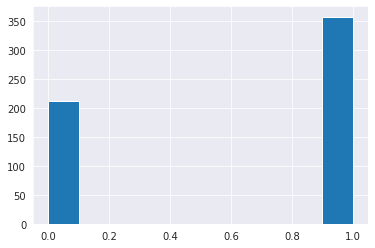

In [3]:
dataset['diagnosis'].hist()

<AxesSubplot:>

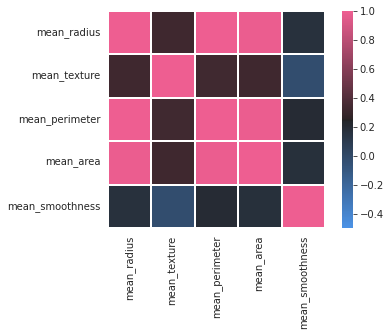

In [4]:
correlation = dataset.iloc[:, :-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(correlation, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
dataset = dataset[['mean_radius', 'mean_texture', 'mean_smoothness', 'diagnosis']]

In [6]:
dataset

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


<AxesSubplot:xlabel='mean_smoothness', ylabel='Count'>

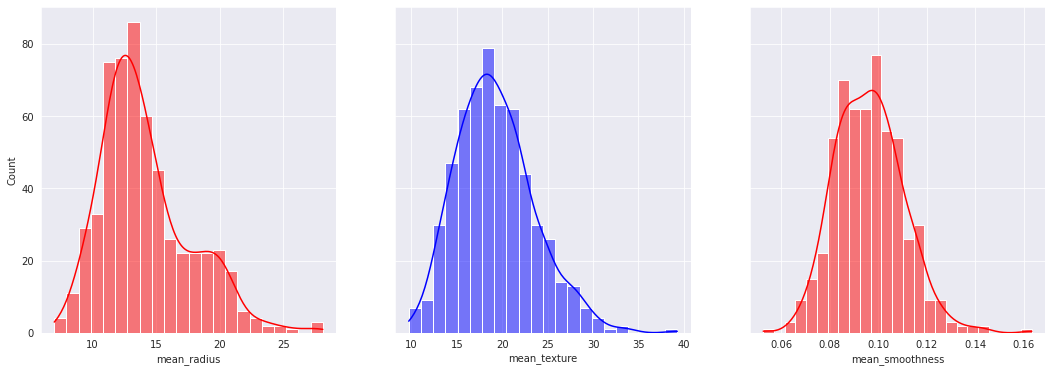

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(dataset, ax=axes[0], x="mean_radius", kde=True, color="r")
sns.histplot(dataset, ax=axes[1], x="mean_texture", kde=True, color="b")
sns.histplot(dataset, ax=axes[2], x="mean_smoothness", kde=True, color="r")

In [8]:
dataset['categorized_mean_radius'] = pd.cut(dataset["mean_radius"].values, bins=3, labels=[0,1,2])
dataset['categorized_mean_texture'] = pd.cut(dataset["mean_texture"].values, bins=3, labels=[0,1,2])
dataset['categorized_mean_smoothness'] = pd.cut(dataset["mean_smoothness"].values, bins=3, labels=[0,1,2])

dataset.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
dataset = dataset[["categorized_mean_radius", "categorized_mean_texture", "categorized_mean_smoothness", "diagnosis"]]
dataset.head(5)

,categorized_mean_radius,categorized_mean_texture,categorized_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0


### calculate P(Y|X) for all possible y

In [9]:
def calculate_prior(dataset, y):
    y_classes = sorted( list( dataset[y].unique() ) )
    priors = []
    for _class in y_classes:
        class_condition = (dataset[y] == _class)
        priors.append( len(dataset[class_condition])/len(dataset) )
    return priors

### Calculate the likelihood P(X=x|Y=y) using Gausian distribution

In [10]:
def calculate_likelihood_ndist(dataset, feature_name, feature_value, Y, Y_label):
    dataset = dataset[dataset[Y] == Y_label]
    p_x_given_y = len(dataset[dataset[feature_name] == feature_value]) / len(dataset)
    return p_x_given_y

### Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) and select the maximum

In [11]:
def naive_bayes_classifier_gaussian(dataset, X, Y):
    features = (dataset.columns)[:-1]
    priors = calculate_prior(dataset, Y)
    
    Y_predicted = []
    
    for x in X:
        Y_labels = list(dataset[Y].unique())
        likelihood = [1]*len(Y_labels)
        
        for j in range(len(Y_labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_ndist(dataset, features[i], x[i], Y, Y_labels[j])
                
        post_prob = [1] * len(Y_labels)
        for i in range(len(Y_labels)):
            post_prob[i] = priors[i] * likelihood[i]
            
        Y_predicted.append(np.argmax(post_prob))
        
    return Y_predicted

In [12]:
def confusion_matrix(truth, predicted):
    tp = len(truth[predicted == 1])
    tn = len(truth[predicted == 0])
    fp = np.sum(truth[(truth == 0) & (predicted == 1)].any())
    fn = np.sum(truth[(truth == 1) & (predicted == 0)].any())
    
    return np.array([[tp, fp], [fn, tn]])

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=.2, random_state=41)

X_test = test.iloc[:, :-1].values
Y_test = test.iloc[:, -1].values

Y_predicted = naive_bayes_classifier_gaussian(train, X_test, Y="diagnosis")

In [14]:
predicted = np.array(Y_predicted)
conf_matrix = confusion_matrix(Y_test, predicted)
conf_matrix

array([[50,  0],
       [ 1, 64]])

In [15]:
list(conf_matrix.ravel())

[50, 0, 1, 64]

In [16]:
def accuracy(tp, fp, fn, tn):
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2*precision*recall/ (precision+recall)
    
    return recall, precision, f1_score

In [17]:
tp, fp, fn, tn = list(conf_matrix.ravel())
recall, precision, f1_score = accuracy(tp, fp, fn, tn)

In [18]:
recall

0.9803921568627451

In [19]:
precision

1.0

In [20]:
f1_score

0.99009900990099